In [1]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

In [20]:
import optimize_property as op
import pandas as pd
import argparse
from models.MolHF import MolHF
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool

In [6]:
from rdkit import Chem

smiles = "CC1(C)C2CCC3(C)C(O)C(=O)C2C14CC34"
mol = Chem.MolFromSmiles(smiles)
formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
print(formula)  # C18H26N2O5S

C14H20O2


In [3]:
train_data = pd.read_csv('./data_preprocessed/zinc250k/zinc250k_property.csv')

In [4]:
data_path = os.path.join('./data_preprocessed', 'zinc250k')
with open(os.path.join(data_path, 'config.txt'), 'r') as f:
    data_config = eval(f.read())

# Предобученная модель для оптимизации

parser = argparse.ArgumentParser()

#общие параметры
parser.dataset = 'zinc250k' 
parser.device = 'cpu' 
parser.seed = 42
parser.save = True
parser.model = 'MolHF'
parser.order = 'bfs'
parser.property_name = 'plogp'

parser.init_checkpoint = './save_pretrain/zinc250k_model/checkpoint.pth'
parser.model_dir = './save_optimization'
parser.property_model_path = 'plogp_moflow_zinc250k_10.pth'

# параметры модели
parser.deq_scale = 0.6 
parser.batch_size = 256
parser.lr = 1e-3 
parser.squeeze_fold = 2 
parser.n_block = 4 
parser.a_num_flows = 6 
parser.num_layers = 2 
parser.hid_dim = 256 
parser.b_num_flows = 3 
parser.filter_size = 256 
parser.temperature = 0.6 
parser.learn_prior = True 
parser.inv_conv = True 
parser.inv_rotate = True 
parser.condition = True
parser.hidden = '32'

parser.num_data = None
parser.is_test_idx = False
parser.num_workers = 0
parser.deq_type = 'random'
parser.debug = 'true'

# опциональные параметры для оптимизации
parser.split = 'moflow'
parser.topk = 30 
parser.num_iter = 10 
parser.opt_lr = 0.5
parser.topscore = False
parser.consopt = True

mol_model = MolHF(data_config, parser)

checkpoint = torch.load('./save_pretrain/zinc250k_model/checkpoint.pth', map_location='cpu')
mol_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
dataset = op.PretrainDataset("./data_preprocessed/{}".format('zinc250k'), data_config, parser)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

reading data from ./data_preprocessed/zinc250k
Atom order: bfs


In [6]:
data_loader

In [7]:
X = np.load("./data_preprocessed/zinc250k/node_features.npy")
A = np.load("./data_preprocessed/zinc250k/adj_features.npy")

In [8]:
ms = np.load("./data_preprocessed/zinc250k/mol_sizes.npy")

In [9]:
ms

array([24, 21, 29, ..., 22, 24, 34], dtype=int64)

In [ ]:
from rdkit.Chem.rdMolDescriptors import CalcNumAtoms
from rdkit.Chem import MolFromSmiles
from tqdm import tqdm

fp = open('./dataset/zinc1500k/zinc1500k.smi', 'r')
smiles_list = [smiles.strip() for smiles in fp]

In [5]:
max_atoms = 0
max_atoms_less_40 = 0
mol_sizes = []

for i, sml in tqdm(enumerate(smiles_list), total=len(smiles_list)):
    # curr = CalcNumAtoms(MolFromSmiles(sml))
    mol_sizes.append(CalcNumAtoms(MolFromSmiles(sml)))
    # max_atoms = curr if curr > max_atoms else max_atoms
    # max_atoms_less_40 = curr if (curr > max_atoms_less_40) & (curr <= 40) else max_atoms_less_40
    # if i % 100000 == 0:
    #     print('Итерация {}, текущий максимум: {}, максимум less_40: {}'.format(i, max_atoms, max_atoms_less_40))

100%|██████████| 1584663/1584663 [05:14<00:00, 5042.29it/s]


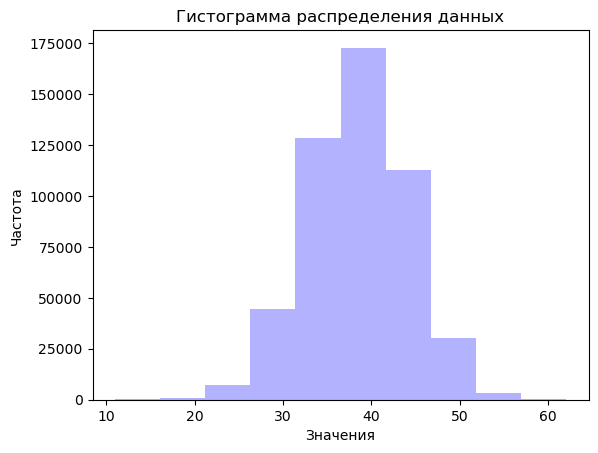

In [18]:
import matplotlib.pyplot as plt

# Создаём гистограмму
plt.hist(mol_sizes[:500000], color='blue', alpha=0.3)
plt.title('Гистограмма распределения данных')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

In [24]:
gen_smiles = pd.read_csv('MolHF_gen.csv').values.ravel().tolist()

In [31]:
x = None
assert(isinstance(x, type(None)))

In [32]:
mol_sizes_gen = []

for i, sml in tqdm(enumerate(gen_smiles), total=len(gen_smiles)):
    # curr = CalcNumAtoms(MolFromSmiles(sml))
    mol = MolFromSmiles(sml)
    if not isinstance(mol, type(None)):
        mol_sizes_gen.append(CalcNumAtoms(mol))

100%|██████████| 30000/30000 [00:04<00:00, 6970.28it/s]


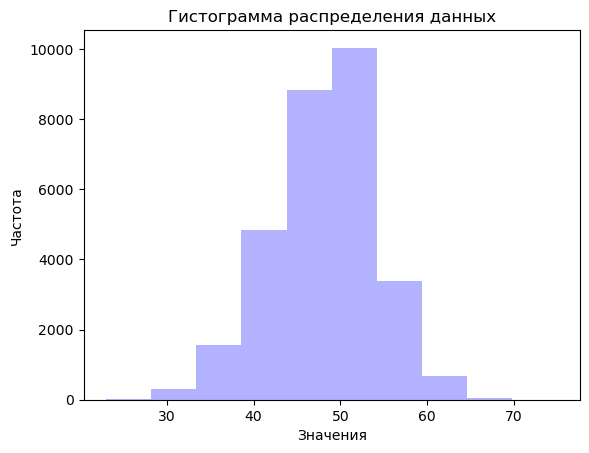

In [33]:
plt.hist(mol_sizes_gen, color='blue', alpha=0.3)
plt.title('Гистограмма распределения данных')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

In [ ]:
def get_num_of_atoms(sml):
    return CalcNumAtoms(MolFromSmiles(sml))

with Pool(processes=torch.multiprocessing.cpu_count()) as pool:
    iter = pool.imap(get_num_of_atoms, smiles_list)
    for _, n in tqdm(enumerate(iter), total=len(smiles_list)):
        max_atoms = n if n > max_atoms else max_atoms

  0%|          | 0/1584663 [00:00<?, ?it/s]

In [ ]:
fp = open('./dataset/zinc250k/zinc250k.smi', 'r')
smiles_list = [smiles.strip() for smiles in fp]

X_list = []
A_list = []

def get_XA(obj):
    return {'X': obj['node'], 'A': obj['adj']}

with Pool(processes=torch.multiprocessing.cpu_count()) as pool:
    iter = pool.imap(get_XA, smiles_list)
    print(type(next(iter)))
    # for _, x, a in tqdm(enumerate(iter), total=len(smiles_list)):
    #     print(_)
    #     X_list.append(x)
    #     A_list.append(a)
        

# for i, obj in tqdm(enumerate(data_loader)):
#     X = obj['node']
#     A = obj['adj']
#     X_list.append(X)
#     A_list.append(A)
    # print(X.shape, A.shape)
    # z, _, _ = mol_model(X, A)
    # z_list.append(mol_model.to_latent_format(z).ravel().detach().numpy())
    # break

In [ ]:
z_list = []
mol_graphs = zip(X_list, A_list)

def process_mol(args):
    return mol_model.forward(*args)

with Pool(processes=torch.multiprocessing.cpu_count()) as pool:
    iter = pool.imap(process_mol, mol_graphs)
    for _, z_vec in tqdm(enumerate(iter)):
        print(_)
        z_list.append(z_vec.ravel().detach().numpy())

0it [00:00, ?it/s]

In [18]:
z_frame = pd.DataFrame(z_list, columns=['SMILES', 'z'])
z_frame.to_csv('mlp_dataset.csv')

In [23]:
pd.read_csv('mlp_dataset.csv')['z'][0]

'[ 0.5415718   0.6663616  -0.2810844  ... -0.04863703 -1.8517721\n -0.5921116 ]'

In [9]:
class simpleMLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )


    def forward(self, x):
        return self.layers(x)

In [3]:
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
trainloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

100%|██████████| 170498071/170498071 [00:21<00:00, 7870354.52it/s]


Extracting c:\Users\Makss\Documents\Учёба\Диплом\NF_mol_gen\my_scripts\cifar-10-python.tar.gz to c:\Users\Makss\Documents\Учёба\Диплом\NF_mol_gen\my_scripts


In [10]:
mlp = simpleMLP()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [11]:
for epoch in range(5):
    print('Epoch: ', epoch + 1)

    current_loss = 0.

    for i, data in enumerate(trainloader):

        inputs, targets = data
        optimizer.zero_grad()
        
        outputs = mlp(inputs)
        loss = loss_func(outputs, targets)

        loss.backward()
        optimizer.step()

        current_loss += loss.item()

        if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
          current_loss = 0.0

print('Training process has finished.')



Epoch:  1
Loss after mini-batch   500: 2.225
Loss after mini-batch  1000: 2.088
Loss after mini-batch  1500: 2.014
Loss after mini-batch  2000: 1.957
Loss after mini-batch  2500: 1.943
Loss after mini-batch  3000: 1.930
Loss after mini-batch  3500: 1.900
Loss after mini-batch  4000: 1.894
Loss after mini-batch  4500: 1.863
Loss after mini-batch  5000: 1.887
Epoch:  2
Loss after mini-batch   500: 1.840
Loss after mini-batch  1000: 1.835
Loss after mini-batch  1500: 1.831
Loss after mini-batch  2000: 1.848
Loss after mini-batch  2500: 1.817
Loss after mini-batch  3000: 1.806
Loss after mini-batch  3500: 1.805
Loss after mini-batch  4000: 1.794
Loss after mini-batch  4500: 1.795
Loss after mini-batch  5000: 1.784
Epoch:  3
Loss after mini-batch   500: 1.788
Loss after mini-batch  1000: 1.774
Loss after mini-batch  1500: 1.750
Loss after mini-batch  2000: 1.758
Loss after mini-batch  2500: 1.757
Loss after mini-batch  3000: 1.740
Loss after mini-batch  3500: 1.746
Loss after mini-batch  40

In [ ]:
mlp